In [411]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
from tqdm import tqdm
utils.rcparams()

In [80]:
herschel = utils.full_loader('herschel')
vla = utils.full_loader('VLA')

In [603]:
class Object:

    def __init__(self, id, ra, dec):
        self.id = id
        self.ra = ra
        self.dec = dec

class Source(Object):
    pass

class Counterpart(Object):

    def __init__(self, id, ra, dec, number):
        super().__init__(id, ra, dec)
        self.number = number

    def separation(self, other):
        d = np.sqrt(((self.ra-other.ra)**2) + ((self.dec-other.dec)**2))*3600
        return d

    def s_value(self, other, area):
        d = self.separation(other)
        s = (self.number/area)*(d**2)
        return s

    def p_value(self, other, area, D):
        s = self.s_value(other, area)
        s_idx = np.argmin(abs(s-D['bin_centers']))
        p = np.trapz(D['dist_norm'][:s_idx])
        if p < 1/D['N']:
            p = 1/D['N']
        return p

In [604]:
def create_source_catalogue(data, id_str, ra_str, dec_str):

    catalogue = []
    for obj in range(len(data)):
        id = data[id_str][obj]
        ra = data[ra_str][obj]
        dec = data[dec_str][obj]
        obj = Source(id, ra, dec)
        catalogue.append(obj)

    return catalogue


def create_counterpart_catalogue(data, id_str, ra_str, dec_str, flux_str):

    numbers = [len(data[data[flux_str] > flux]) for flux in data[flux_str]]

    catalogue = []
    for obj in range(len(data)):
        id = data[id_str][obj]
        ra = data[ra_str][obj]
        dec = data[dec_str][obj]
        num = numbers[obj]
        obj = Counterpart(id, ra, dec, num)
        catalogue.append(obj)

    return catalogue

In [605]:
herschel_objects = create_source_catalogue(herschel, 'id_her', 'RA_her', 'Dec_her')
vla_objects = create_counterpart_catalogue(vla, 'id_cos', 'RA_cos', 'Dec_cos', 'total_int_flux')

In [638]:
class Survey:

    def __init__(self, sources, counterparts, n_random=100000):
        self.sources_all = sources
        self.counterparts_all = counterparts

        # Define the overlapping survey area
        sources_ra = [self.sources_all[obj].ra for obj in range(len(self.sources_all))]
        sources_dec = [self.sources_all[obj].dec for obj in range(len(self.sources_all))]
        counterparts_ra = [self.counterparts_all[obj].ra for obj in range(len(self.counterparts_all))]
        counterparts_dec = [self.counterparts_all[obj].dec for obj in range(len(self.counterparts_all))]
        self.ra_min, self.ra_max = max(min(sources_ra), min(counterparts_ra)), min(max(sources_ra), max(counterparts_ra))
        self.dec_min, self.dec_max = max(min(sources_dec), min(counterparts_dec)), min(max(sources_dec), max(counterparts_dec))
        self.area_deg = (abs(self.ra_max - self.ra_min)) * (abs(self.dec_max - self.dec_min))
        self.area_arcsec = (np.sqrt(self.area_deg)*3600)**2

        # Reduce samples to within borders
        self.sources = [obj for obj in self.sources_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        self.counterparts = [obj for obj in self.counterparts_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]

        # Create a set of N random counterparts
        self.random_sources = []
        for i in range(n_random):
            ra_random, dec_random = np.random.uniform(self.ra_min, self.ra_max), np.random.uniform(self.dec_min, self.dec_max)
            object_random = Source(i, ra_random, dec_random)
            self.random_sources.append(object_random)


    def get_s_values(self, objects, r_max):

        if objects == 'real':
            sources = self.sources
        elif objects == 'random':
            sources = self.random_sources
        else:
            raise ValueError('Please provide "real" or "random" for first argument.')

        min_s_sources = []
        for source in tqdm(sources, desc='Calculating S Values'):
            counterpart_s_values = []
            for counterpart in self.counterparts:
                d = counterpart.separation(source)
                if d <= r_max:
                    s = counterpart.s_value(source, self.area_arcsec)
                    counterpart_s_values.append(s)
            min_s = min(counterpart_s_values, default=np.nan)
            min_s_sources.append(min_s)
        return min_s_sources


    def get_s_distribution(self, r_max, n_bins=100):
        N = len(self.random_sources)
        min_s_random = self.get_s_values('random', r_max)
        min_s_random_finite = np.array([s for s in min_s_random if np.isfinite(s)])
        s_hist, bin_edges = np.histogram(min_s_random_finite, bins=np.logspace(-8,0,n_bins))
        s_hist_norm = s_hist/N
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        return {'N': N,
                'dist': s_hist,
                'dist_norm': s_hist_norm,
                'bin_centers': bin_centers}


    def get_p_values(self, D, r_max):

        source_ids = []
        counterpart_ids = []
        counterpart_d_values = []
        counterpart_p_values = []
        for source in tqdm(self.sources, desc='Calculating P Values'):
            for counterpart in self.counterparts:
                d = counterpart.separation(source)
                if d <= r_max:
                    p = counterpart.p_value(source, self.area_arcsec, D)
                    source_ids.append(source.id)
                    counterpart_ids.append(counterpart.id)
                    counterpart_d_values.append(d)
                    counterpart_p_values.append(p)

        return {'source_ids': source_ids,
                'counterpart_ids': counterpart_ids,
                'Separation': counterpart_d_values,
                'P_values': counterpart_p_values}


In [639]:
cosmos = Survey(herschel_objects, vla_objects)

### Survey Coverage

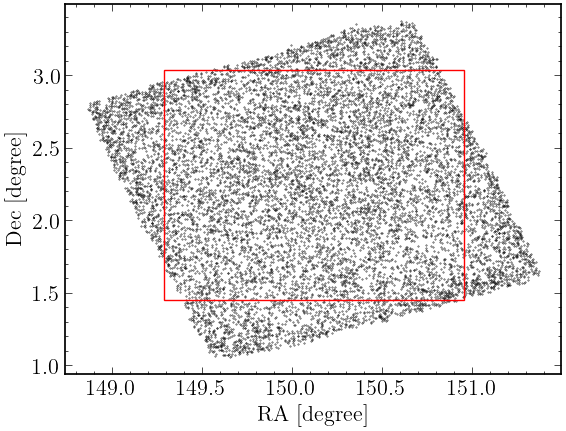

In [86]:
sources_ra_all = [cosmos.sources_all[obj].ra for obj in range(len(cosmos.sources_all))]
sources_dec_all = [cosmos.sources_all[obj].dec for obj in range(len(cosmos.sources_all))]

fig, ax = plt.subplots()
ax.scatter(sources_ra_all, sources_dec_all, s=0.1)
ax.add_patch(Rectangle((cosmos.ra_min, cosmos.dec_min), cosmos.ra_max-cosmos.ra_min, cosmos.dec_max-cosmos.dec_min, edgecolor='r', facecolor='none'))
ax.set_xlabel(r'RA [degree]')
ax.set_ylabel(r'Dec [degree]')
plt.show()

### Optimal Radial Cutoff

### D(S) Functions

In [608]:
r = 20
s_random = cosmos.get_s_values('random', r)
s_herschel = cosmos.get_s_values('real', r)

Calculating S Values: 100%|██████████| 7230/7230 [00:45<00:00, 158.31it/s]


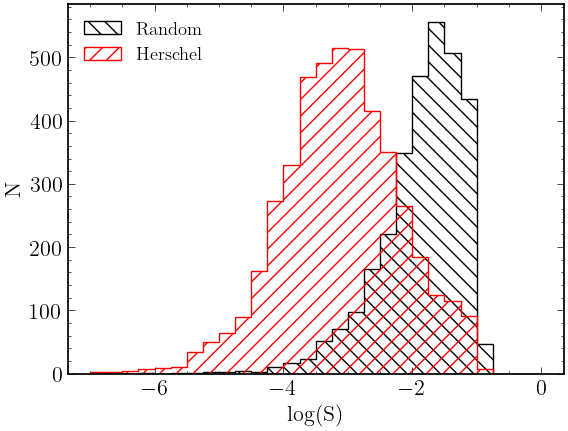

In [610]:
fig, ax = plt.subplots()
ax.hist(np.log10(s_random), range=(-7,0), bins=28, histtype='step', hatch=r'\\', label='Random')
ax.hist(np.log10(s_herschel), range=(-7,0), bins=28, histtype='step', hatch=r'//', label='Herschel')
ax.set_xlabel(r'log(S)')
ax.set_ylabel(r'N')
ax.legend(loc='upper left')
plt.show()

In [666]:
D_20 = cosmos.get_s_distribution(8, n_bins=1000)

Calculating S Values: 100%|██████████| 100000/100000 [10:35<00:00, 157.40it/s]


### Identifying IDs

In [667]:
ids = cosmos.get_p_values(D_20, 8)

Calculating P Values: 100%|██████████| 7230/7230 [00:45<00:00, 159.09it/s]


In [668]:
herschel_cut = herschel[(herschel['RA_her'] > cosmos.ra_min) & (herschel['RA_her'] < cosmos.ra_max) & (herschel['Dec_her'] > cosmos.dec_min) & (herschel['Dec_her'] < cosmos.dec_max)]
vla_cut = vla[(vla['RA_cos'] > cosmos.ra_min) & (vla['RA_cos'] < cosmos.ra_max) & (vla['Dec_cos'] > cosmos.dec_min) & (vla['Dec_cos'] < cosmos.dec_max)]

In [669]:
all_ids = []
for source_id, counterpart_id, idx in zip(ids['source_ids'], ids['counterpart_ids'], range(len(ids['source_ids']))):
    source = herschel_cut[herschel_cut['id_her'] == source_id].reset_index()
    counterpart = vla_cut[vla_cut['id_cos'] == counterpart_id].reset_index()
    d = pd.Series(ids['Separation'][idx], name='Separation')
    p = pd.Series(ids['P_values'][idx], name='P_values')
    join = pd.concat([source, counterpart, d, p], axis=1)
    all_ids.append(join)

herschel_vla_all = pd.concat(all_ids).reset_index()
herschel_no_vla = herschel_cut[~herschel_cut['id_her'].isin(herschel_vla_all['id_her'])]

In [670]:
herschel_vla_all

,level_0,index,id_her,RA_her,Dec_her,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,...,Decerr_cos,total_int_flux,total_int_flux_err,rms,snr,Npix,resolved,multi_comp,Separation,P_values
0,0,3,4,150.745831,2.343037,0.359749,0.002514,0.170467,0.002517,0.071225,...,0.010,5940.0,300.0,4.30,1300.00,108,1,0,0.893782,0.000020
1,0,5,6,149.773592,2.636177,0.230962,0.002527,0.108277,0.002489,0.040625,...,9.999,948.0,-99.0,2.50,-99.00,1327,1,1,2.091260,0.000510
2,0,7,8,150.033571,2.764824,0.198343,0.002542,0.076450,0.002527,0.030536,...,9.999,508.0,-99.0,2.50,-99.00,397,1,1,1.400477,0.000380
3,0,10,11,149.923969,3.032549,0.209009,0.003341,0.084709,0.003298,0.029999,...,0.028,604.0,34.0,15.10,20.10,67,1,0,1.359809,0.000325
4,0,12,13,150.501335,2.862531,0.182481,0.002545,0.076737,0.002548,0.025080,...,0.014,604.0,30.0,2.72,54.20,399,1,0,2.435724,0.000995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4560,0,11176,11177,150.502838,2.222572,0.017136,0.002501,0.021804,0.002492,0.013954,...,0.055,26.0,3.0,2.61,9.99,26,0,0,7.009632,0.046420
4561,0,11180,11181,150.037239,1.819571,0.012254,0.002577,0.008627,0.002536,0.004517,...,0.071,17.7,2.5,2.32,7.64,24,0,0,7.323521,0.054805
4562,0,11180,11181,150.037239,1.819571,0.012254,0.002577,0.008627,0.002536,0.004517,...,0.062,19.8,2.5,2.26,8.75,27,0,0,7.891518,0.056055
4563,0,11181,11182,150.450712,2.816442,0.012734,0.002513,0.016243,0.002472,0.013505,...,0.068,23.8,2.6,2.27,8.02,27,1,0,2.355588,0.011845


In [671]:
len(herschel_vla_all[herschel_vla_all['P_values'] < 0.05])/len(herschel_vla_all)

0.9511500547645126

In [672]:
len(herschel_vla_all[herschel_vla_all['P_values'] < 0.1])/len(herschel_vla_all)

1.0

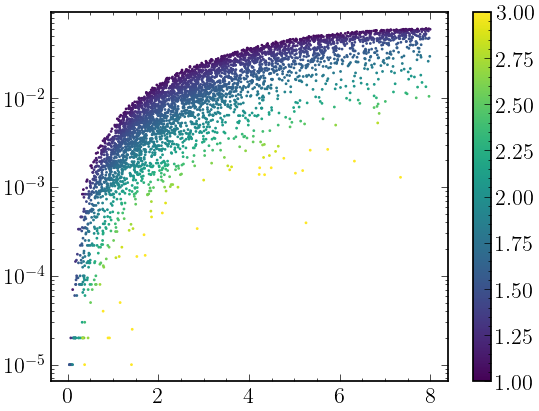

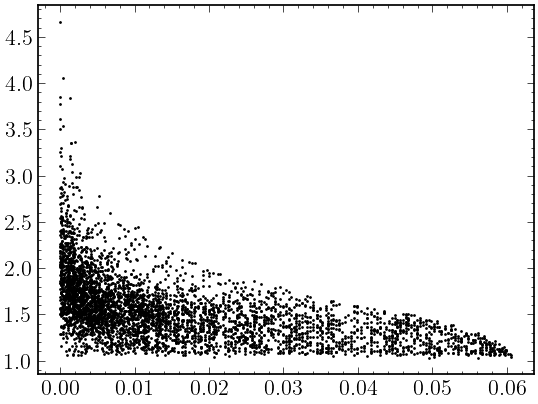

In [673]:
fig, ax = plt.subplots()
sc=ax.scatter(herschel_vla_all['Separation'], herschel_vla_all['P_values'], c=np.log10(herschel_vla_all['total_int_flux']), vmin=1, vmax=3, s=1)
ax.semilogy()
plt.colorbar(sc)
plt.show()

fig, ax = plt.subplots()
ax.scatter(herschel_vla_all['P_values'], np.log10(herschel_vla_all['total_int_flux']), s=1)
plt.show()

### Submm-Radio Radial Offsets

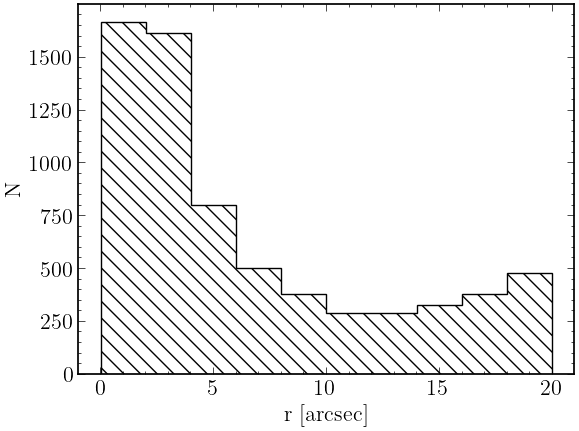

In [621]:
fig, ax = plt.subplots()
ax.hist(herschel_vla_all['Separation'], histtype='step', hatch=r'\\')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
plt.show()

### Sub-mm Colours

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


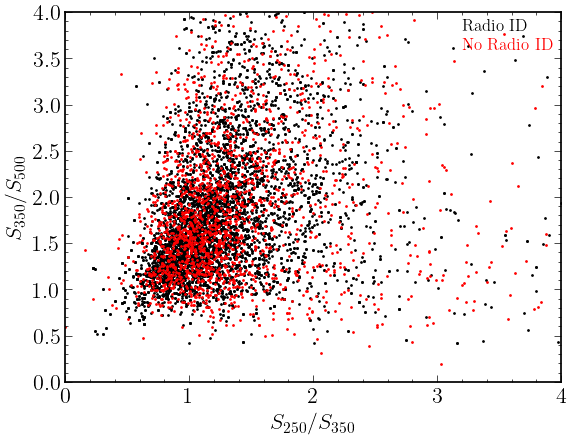

In [622]:
fig, ax = plt.subplots()
ax.scatter(herschel_vla_all['F_BLIND_MF_SPIRE_250']/herschel_vla_all['F_BLIND_MF_SPIRE_350'], herschel_vla_all['F_BLIND_MF_SPIRE_350']/herschel_vla_all['F_BLIND_MF_SPIRE_500'], s=1)
ax.scatter(herschel_no_vla['F_BLIND_MF_SPIRE_250']/herschel_no_vla['F_BLIND_MF_SPIRE_350'], herschel_no_vla['F_BLIND_MF_SPIRE_350']/herschel_no_vla['F_BLIND_MF_SPIRE_500'], s=1)
ax.text(0.8, 0.95, 'Radio ID', transform=ax.transAxes, c='k', fontsize=12)
ax.text(0.8, 0.9, 'No Radio ID', transform=ax.transAxes, c='r', fontsize=12)
ax.set_xlabel(r'$S_{250}/S_{350}$')
ax.set_ylabel(r'$S_{350}/S_{500}$')
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.legend()
plt.show()